### Model training code

In [28]:
# The dataset consists of chest X-ray images (anterior-posterior) that were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert. \
# The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

# wget https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download
# unzip archive.zip

In [1]:
%matplotlib inline

import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dataset = datasets.ImageFolder('./chest_xray/train', transform=transform)
val_dataset = datasets.ImageFolder('./chest_xray/val', transform=transform)
test_dataset = datasets.ImageFolder('./chest_xray/test', transform=transform)

In [6]:
labels = [v[-1] for v in train_dataset]

<BarContainer object of 2 artists>

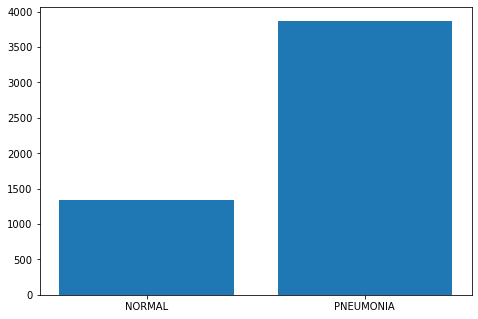

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(train_dataset.classes, [len(labels)-sum(labels), sum(labels)])

In [9]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
batch = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

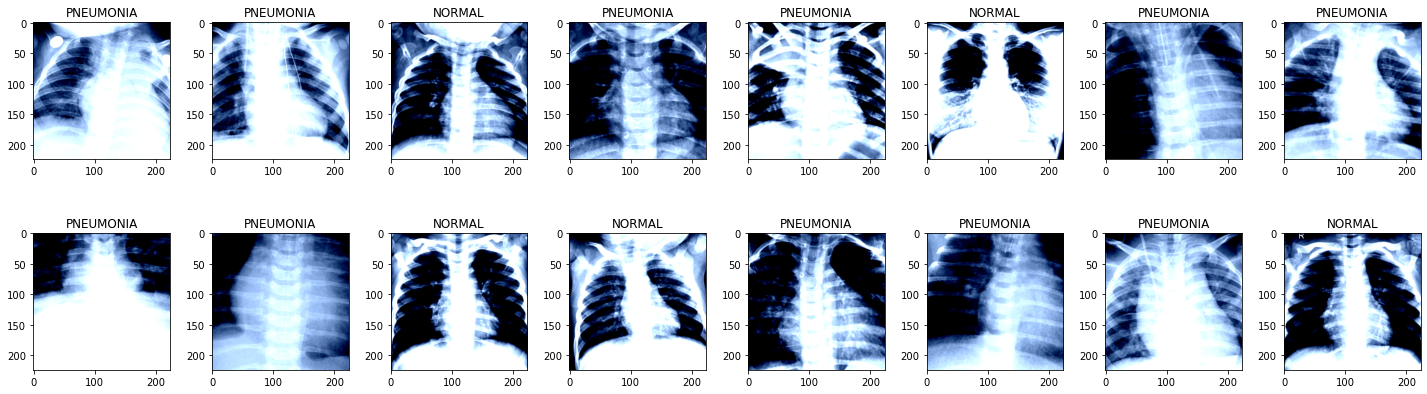

In [11]:
nrows = 2
ncols=BATCH_SIZE//nrows
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6))
fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        ind = j if not i else ncols + j
        ax[i, j].imshow(batch[0][ind].permute(1, 2, 0))
        ax[i, j].set_title(train_dataset.classes[batch[1][ind]])

In [29]:
# model = models.vgg16(pretrained=True)
model = models.resnet50(pretrained=True)

In [34]:
# for param in model.features.parameters():
#     param.required_grad = False

# n_inputs = model.classifier[6].in_features
# n_classes = len(train_dataset.classes)
# model.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
#                                     nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

for param in model.fc.parameters():
    param.require_grad = False 
    
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [14]:
EPOCHS = 25

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# weight = torch.FloatTensor([(len(labels)-sum(labels)) / len(train_dataset), sum(labels) / len(train_dataset)]).to(device)
# criterion = nn.CrossEntropyLoss(weight=weight)

In [184]:
best_weights = copy.deepcopy(model.state_dict())
best_acc = 0
history_loss = [] 
history_acc = []

for epoch in tqdm(range(EPOCHS)):
    for phase in ['train', 'val']:
        if phase == 'train':
            cur_dataloader = train_dataloader
            scheduler.step()
            model.train()            
        else:
            cur_dataloader = val_dataloader
            model.eval()
            

        c_loss = 0
        c_acc = 0
        
        for data in cur_dataloader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            c_loss += loss.item() * inputs.size(0)
            c_acc += torch.sum(preds == labels.data)
            
        history_loss.append(c_loss / len(cur_dataloader.dataset))
        history_acc.append(c_acc / len(cur_dataloader.dataset))

        if phase == 'val':
            if history_acc[-1] > best_acc:
                best_acc = history_acc[-1]
                best_weights = copy.deepcopy(model.state_dict())

print(f'Best val Acc: {best_acc}')
model.load_state_dict(best_weights)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\Ignat\.conda\envs\general\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:25:37<00:00, 205.51s/it]

Best val Acc: 1.0


<All keys matched successfully>

Text(0.5, 0, 'epoch')

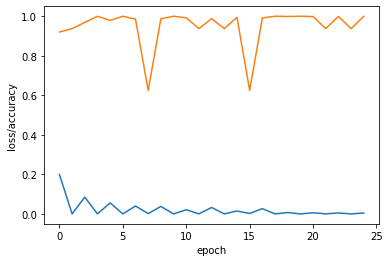

In [204]:
plt.plot(history_loss)
plt.plot(history_acc)
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')

In [26]:
c_acc = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)            

        c_acc += (preds == labels).sum().item()
        
    acc = c_acc / len(test_dataloader.dataset)

In [206]:
print(f"Accuracy: {acc}")

Accuracy: 0.9189743589743589


In [20]:
model_path = 'vgg16_pneumonia.pth'

torch.save(model.state_dict(), f'{model_path}')